In [1]:
!pip install tensorflow

In [2]:
!pip install joblib

In [ ]:
# url = "https://github.com/algonacci/DataSetBatik/tree/master/CitraBatik"
# roboflow = https://universe.roboflow.com/apriliaagrn/motif-batik-idv6s

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from PIL import Image
from shutil import copy2
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix, f1_score

In [4]:
# pake zip dataset drive
import zipfile
import gdown

url = "https://drive.google.com/uc?export=download&id=1Jh8EumXOilphcp2wb1GT3ReFl37WJ2uW"
output = "Motif_Batik_Dataset.zip"
gdown.download(url, output, quiet=False)

zip_ref = zipfile.ZipFile("/content/Motif_Batik_Dataset.zip", 'r')
zip_ref.extractall("dataset")
zip_ref.close()

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1Jh8EumXOilphcp2wb1GT3ReFl37WJ2uW
From (redirected): https://drive.google.com/uc?export=download&id=1Jh8EumXOilphcp2wb1GT3ReFl37WJ2uW&confirm=t&uuid=cfcf9998-43f9-4911-8680-f8c5e3a0cefc
To: /content/Motif_Batik_Dataset.zip
100%|██████████| 330M/330M [00:01<00:00, 192MB/s]


# Split data train val test

In [5]:
# Define Directories for Dataset
base_dir = r'/content/dataset/Motif_Batik_Dataset'

train_dir = r'/content/train'
val_dir = r'/content/val'
test_dir = r'/content/test'

# Create directories for train, val, and test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all class names (folder names)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Create class directories in train, val, and test folders
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

In [6]:
# Split data dan bagi jadi 3 folder baru test, train, val trus diisi
for cls in classes:
    cls_dir = os.path.join(base_dir, cls)
    images = os.listdir(cls_dir)
    images = [img for img in images if os.path.isfile(os.path.join(cls_dir, img))]

    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        copy2(os.path.join(cls_dir, img), os.path.join(train_dir, cls))
    for img in val_imgs:
        copy2(os.path.join(cls_dir, img), os.path.join(val_dir, cls))
    for img in test_imgs:
        copy2(os.path.join(cls_dir, img), os.path.join(test_dir, cls))

In [7]:
def check_image_shapes(directory):
    shapes = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
                file_path = os.path.join(root, file)
                with Image.open(file_path) as img:
                    shapes.append(img.size)
    return shapes

# Fungsi untuk menghitung jumlah gambar dalam direktori tertentu
def count_images(directory):
    count = 0
    for root, _, files in os.walk(directory):
        count += len([file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))])
    return count

In [8]:
# Mengecek shape gambar di training set
train_shapes = check_image_shapes(train_dir)

# Menampilkan shape gambar dalam training set
print(f"Shape gambar dalam training set: {train_shapes[0]}")

Shape gambar dalam training set: (640, 640)


In [ ]:
# # # undersampling

# from imblearn.under_sampling import RandomUnderSampler
# import os
# from shutil import copy2
# import numpy as np
# from PIL import Image

# # Hypothetical feature extraction function
# def extract_features(image_path):
#     try:
#         # Open the image
#         with Image.open(image_path) as img:
#             # Convert the image to grayscale
#             img = img.convert('L')
#             # Resize the image to a fixed size (e.g., 64x64)
#             img = img.resize((64, 64))
#             # Flatten the image to a 1D array
#             features = np.array(img).flatten()
#             return features
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# # Initialize RandomUnderSampler
# undersampler = RandomUnderSampler()

# # Define classes and training directory
# classes = ['Batik Bali', 'Batik Betawi', 'Batik Celup', 'Batik Cendrawasih', 'Batik Dayak', 'Batik Geblek Renteng', 'Batik Insang', 'Batik Kawung',
#            'Batik Lasem', 'Batik Megamendung', 'Batik Pala', 'Batik Parang', 'Batik Poleng', 'Batik Sekar Jagad', 'Batik Tambal']
# train_dir = '/content/train'

# # Check if the training directory exists
# if not os.path.exists(train_dir):
#     print(f"Training directory '{train_dir}' does not exist.")
# else:
#     # Collect all training images and labels from all classes
#     X_train = []
#     y_train = []
#     image_paths = []

#     for cls in classes:
#         train_cls_dir = os.path.join(train_dir, cls)
#         if not os.path.exists(train_cls_dir):
#             print(f"Class directory '{train_cls_dir}' does not exist.")
#             continue  # Skip this class if the directory does not exist

#         train_imgs = os.listdir(train_cls_dir)
#         for img in train_imgs:
#             img_path = os.path.join(train_cls_dir, img)
#             features = extract_features(img_path)
#             if features is not None:
#                 X_train.append(features)
#                 y_train.append(cls)
#                 image_paths.append(img_path)

#     # Convert to numpy arrays
#     X_train = np.array(X_train)
#     y_train = np.array(y_train)

#     # Perform undersampling on the entire training dataset
#     X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

#     # Copy images to the training directory with the undersampled dataset
#     for idx, (features, label) in enumerate(zip(X_train_resampled, y_train_resampled)):
#         original_idx = np.where((X_train == features).all(axis=1))[0][0]
#         original_img_path = image_paths[original_idx]
#         class_name = label
#         destination_dir = os.path.join(train_dir, class_name)

#         if not os.path.exists(destination_dir):
#             os.makedirs(destination_dir)

#         new_img_path = os.path.join(destination_dir, f'undersampled_{idx}.jpg')

#         # Only copy if the new path is different from the original path
#         if new_img_path != original_img_path:
#             copy2(original_img_path, new_img_path)


In [9]:
# oversampling

from imblearn.over_sampling import SMOTE
import os
from shutil import copy2
import numpy as np
from PIL import Image

# Hypothetical feature extraction function
def extract_features(image_path):
    try:
        # Open the image
        with Image.open(image_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')
            # Resize the image to a fixed size
            img = img.resize((224, 224))
            # Flatten the image to a 1D array
            features = np.array(img).flatten()
            return features
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Initialize SMOTE
smote = SMOTE()

# Define classes and training directory
classes = ['Batik Bali', 'Batik Betawi', 'Batik Celup', 'Batik Cendrawasih', 'Batik Dayak', 'Batik Geblek Renteng', 'Batik Insang', 'Batik Kawung',
           'Batik Lasem', 'Batik Megamendung', 'Batik Pala', 'Batik Parang', 'Batik Poleng', 'Batik Sekar Jagad', 'Batik Tambal']
train_dir = '/content/train'

# Check if the training directory exists
if not os.path.exists(train_dir):
    print(f"Training directory '{train_dir}' does not exist.")
else:
    # Collect all training images and labels from all classes
    X_train = []
    y_train = []
    image_paths = []

    for cls in classes:
        train_cls_dir = os.path.join(train_dir, cls)
        if not os.path.exists(train_cls_dir):
            print(f"Class directory '{train_cls_dir}' does not exist.")
            continue  # Skip this class if the directory does not exist

        train_imgs = os.listdir(train_cls_dir)
        for img in train_imgs:
            img_path = os.path.join(train_cls_dir, img)
            features = extract_features(img_path)
            if features is not None:
                X_train.append(features)
                y_train.append(cls)
                image_paths.append(img_path)

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Perform oversampling on the entire training dataset
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Copy images to the training directory with the oversampled dataset
    for idx, (features, label) in enumerate(zip(X_train_resampled, y_train_resampled)):
        original_idx = idx % len(image_paths)
        original_img_path = image_paths[original_idx]
        class_name = label
        destination_dir = os.path.join(train_dir, class_name)

        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir)

        new_img_path = os.path.join(destination_dir, f'oversampled_{idx}.jpg')

        # Only copy if the new path is different from the original path
        if new_img_path != original_img_path:
            copy2(original_img_path, new_img_path)

In [10]:
TRAINING_DIR = r'/content/train'
train_datagen = ImageDataGenerator(
                    rescale = 1.0 / 255.0,
                    rotation_range = 40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    zoom_range= 0.2,
                    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

VALIDATION_DIR = r'/content/val'
val_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

TESTING_DIR = r'/content/test'
test_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

testing_generator = test_datagen.flow_from_directory(
    TESTING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

Found 7570 images belonging to 15 classes.
Found 441 images belonging to 15 classes.
Found 448 images belonging to 15 classes.


# CNN

In [ ]:
# Transfer Learning

# base_model = tf.keras.applications.VGG16(include_top=False,
#                                          weights='imagenet',
#                                          input_shape=(380, 380, 3))
# base_model.trainable = False

Pembuatan model CNN pada keras mirip dengan pembuatan model Multi Layer Perceptron (MLP) yang dibahas pada modul sebelumnya. Perbedaannya terdapat pada empat lapis layer konvolusi dan max pooling.

In [ ]:
# num_classes = 15  # ada 15 class

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu', input_shape=(380, 380, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Conv2D(256, (3, 3), 1, activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),

#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dense(num_classes, activation='softmax')  # num_classes should be > 1 for multi-class classification
# ])

# model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 378, 378, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 189, 189, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 187, 187, 32)      9248      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 93, 93, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 91, 91, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 45, 45, 64)       

# Transfer Learning

In [19]:
# VERSI 1
# jumlah kelas
num_classes = 15

# ukuran input shape
input_shape = (224, 224, 3)  # Assuming you're using VGG16 which requires 224x224 images

# Load the pre-trained VGG16 model (include_top=False to exclude the fully connected layers)
base_model = tf.keras.applications.VGG16(include_top=False,
                                         weights='imagenet',
                                         input_shape=(224, 224, 3))
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers so they're not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze beberapa lapisan terakhir
# for layer in base_model.layers[-4:]:  # Membuka freeze 4 lapisan terakhir
#     layer.trainable = True

# Global Average Pooling layer can be used instead of Flatten
# x = GlobalAveragePooling2D()(x)

# Add new fully connected layers on top of the pre-trained layers
x = base_model.output
x = Conv2D(512, (3, 3), activation='relu')(x)
# x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(1024, activation = "relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(256, (3, 3), padding = 'same', activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min')
]

In [ ]:
# # VERSI 2

# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import VGG16

# # jumlah kelas
# num_classes = 15

# # ukuran input shape
# input_shape = (224, 224, 3)  # Assuming you're using VGG16 which requires 224x224 images

# # Load the pre-trained VGG16 model (include_top=False to exclude the fully connected layers)
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# # Freeze the pre-trained layers so they're not updated during training
# for layer in base_model.layers:
#     layer.trainable = False

# # Define your top layers
# x = tf.keras.layers.Conv2D(filters = 128, padding='same', kernel_size = 3, strides = 1, activation='relu')(base_model.output)
# x = tf.keras.layers.MaxPooling2D(2, 2)(x)
# x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
# # x = tf.keras.layers.MaxPooling2D(2, 2)(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# # Create the final model
# model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# model.summary()

# # Callbacks
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks = [
#     ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
#     EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min')
# ]

kalo param gede mbnya mungkin,
Regularisasi: Menggunakan teknik regularisasi seperti dropout, L2 regularization, atau early stopping untuk mengurangi risiko overfitting.

Data Augmentation: Meningkatkan ukuran dan keragaman dataset dengan teknik data augmentation untuk membantu model generalisasi lebih baik.

Model Compression:Menggunakan teknik kompresi model seperti pruning, quantization, atau distillation untuk mengurangi ukuran model tanpa mengorbankan performa secara signifikan.

In [20]:
'''
tahap selanjutnya adalah melakukan compile model tersebut menggunakan fungsi compile(). Pada tahap ini, kita juga menentukan loss function serta optimizer yang akan digunakan.
Loss function yang digunakan pada kasus klasifikasi biner adalah "binary_crossentropy". Selain itu, optimizer yang digunakan  pada kasus ini adalah "Adam optimizer".
Adam optimizer dipilih karena mudah diterapkan, lebih efisien secara komputasi dan kebutuhan memori yang lebih kecil.
'''
from keras.optimizers import Adam
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam', #tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics = ['accuracy'])

# Print model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [21]:
# menghitung step per epochnya

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 236
Validation steps: 13


In [22]:
# latih model dengan model.fit
# logdir = "logs"
# tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 15,
    batch_size=32,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

Epoch 1/15
236/236 [==============================] - ETA: 0s - loss: 1.8091 - accuracy: 0.4373

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


236/236 [==============================] - 119s 494ms/step - loss: 1.8091 - accuracy: 0.4373 - val_loss: 1.4159 - val_accuracy: 0.5433 - lr: 0.0010
Epoch 2/15
236/236 [==============================] - 117s 496ms/step - loss: 1.2402 - accuracy: 0.6031 - val_loss: 1.0845 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 3/15
236/236 [==============================] - 118s 496ms/step - loss: 1.0771 - accuracy: 0.6611 - val_loss: 1.0497 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 4/15
236/236 [==============================] - 116s 488ms/step - loss: 0.9825 - accuracy: 0.6896 - val_loss: 0.9527 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/15
236/236 [==============================] - 118s 501ms/step - loss: 0.9097 - accuracy: 0.7127 - val_loss: 0.9044 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 6/15
236/236 [==============================] - 116s 489ms/step - loss: 0.8771 - accuracy: 0.7238 - val_loss: 0.9414 - val_accuracy: 0.6947 - lr: 0.0010
Epoch 7/15
236/236 [==============================] - 143

# Import ke Tflite, Json, H5

In [ ]:
# import ke h5

model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# import ke tflite
model = tf.keras.models.load_model("model.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_tflite = converter.convert()

# Save the converted model to a .tflite file
with open("CNN_TransferLearningModel.tflite", "wb") as f:
    f.write(model_tflite)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# import ke json

import json

model = tf.keras.models.load_model("model.h5")

# Save the model architecture to a JSON file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# # import ke bin

# import joblib
# import pickle

# # Simpan model ke file biner
# with open('model.bin', 'wb') as file:
#     pickle.dump(model, file)

# # Verifikasi bahwa model yang dimuat dapat digunakan
# loaded_model.summary()

# Cek Grafik

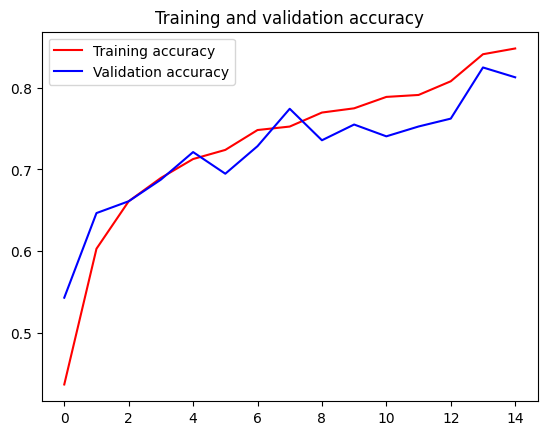

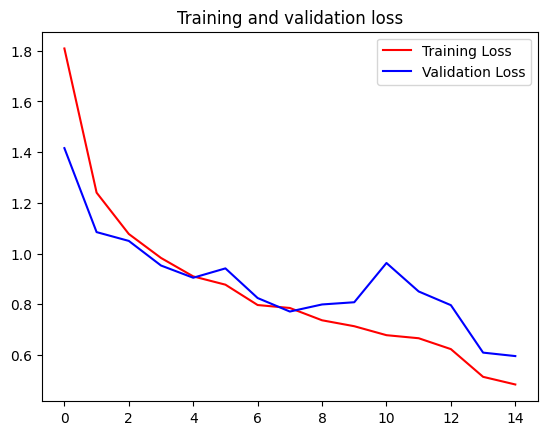

In [23]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Tes Prediksi

In [24]:
# Melakukan Prediksi
testing_steps = testing_generator.samples // testing_generator.batch_size
predictions = model.predict(testing_generator, steps=testing_steps)

14/14 [==============================] - 2s 140ms/step


In [25]:
# Mendapatkan nama kelas dari generator
class_indices = train_generator.class_indices

# Membalikkan dictionary untuk mendapatkan nama kelas dari indeks
labels = {v: k for k, v in class_indices.items()}

# Mengambil label asli dari testing_generator
true_classes = testing_generator.classes

# Mendapatkan nama kelas dari label asli
true_labels = [labels[i] for i in true_classes]

# Mendapatkan nama file dari testing_generator
filenames = testing_generator.filenames

# Menghitung jumlah langkah untuk dataset testing
testing_steps = testing_generator.samples // testing_generator.batch_size

# Jika ada sisa batch, tambahkan satu langkah lagi
if testing_generator.samples % testing_generator.batch_size != 0:
    testing_steps += 1

# Lakukan prediksi
predictions = model.predict(testing_generator, steps=testing_steps)

for i, pred in enumerate(predictions):
    # Membulatkan nilai probabilitas menjadi 2 angka di belakang koma
    rounded_classes = np.round(pred, 2)

    # Mendapatkan indeks kelas dengan prediksi tertinggi
    predicted_class_index = np.argmax(pred)
    predicted_class_label = labels[predicted_class_index]

    # Mendapatkan label asli dari indeks
    true_label = true_labels[i]

    print(f"File: {filenames[i]}")
    print(f"True class: {true_label}")
    print(f"Predicted class: {predicted_class_label} (index: {predicted_class_index})")
    print(f"Prediction probabilities: {rounded_classes}")
    print()

14/14 [==============================] - 2s 140ms/step
File: Batik Bali/16_jpg.rf.a96fdc01676295bfe0607442e1c1e5f5.jpg
True class: Batik Bali
Predicted class: Batik Tambal (index: 14)
Prediction probabilities: [0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.99]

File: Batik Bali/1_jpg.rf.8ff8d69c505f881ef124e11d49e9194f.jpg
True class: Batik Bali
Predicted class: Batik Geblek Renteng (index: 5)
Prediction probabilities: [0.   0.07 0.   0.01 0.04 0.82 0.   0.   0.   0.03 0.01 0.   0.   0.
 0.01]

File: Batik Bali/21_jpg.rf.19bf1c594247eea65af19d11ad09f13c.jpg
True class: Batik Bali
Predicted class: Batik Sekar Jagad (index: 13)
Prediction probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

File: Batik Bali/24_jpg.rf.1776f3c3446898f25a49ef8314b7be68.jpg
True class: Batik Bali
Predicted class: Batik Sekar Jagad (index: 13)
Prediction probabilities: [0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.98
 0.  ]

File: Batik Bali/24_jpg.rf.9

# Evaluasi Model

14/14 [==============================] - 2s 141ms/step

Classification Report:
                      precision    recall  f1-score   support

          Batik Bali       0.06      0.07      0.07        28
        Batik Betawi       0.14      0.12      0.13        25
         Batik Celup       0.11      0.10      0.10        21
   Batik Cendrawasih       0.00      0.00      0.00        28
         Batik Dayak       0.08      0.09      0.08        34
Batik Geblek Renteng       0.12      0.12      0.12        34
        Batik Insang       0.10      0.09      0.09        34
        Batik Kawung       0.05      0.06      0.06        34
         Batik Lasem       0.07      0.07      0.07        29
   Batik Megamendung       0.10      0.11      0.10        28
          Batik Pala       0.08      0.09      0.09        33
        Batik Parang       0.10      0.09      0.10        34
        Batik Poleng       0.06      0.06      0.06        31
   Batik Sekar Jagad       0.11      0.12      0.12 

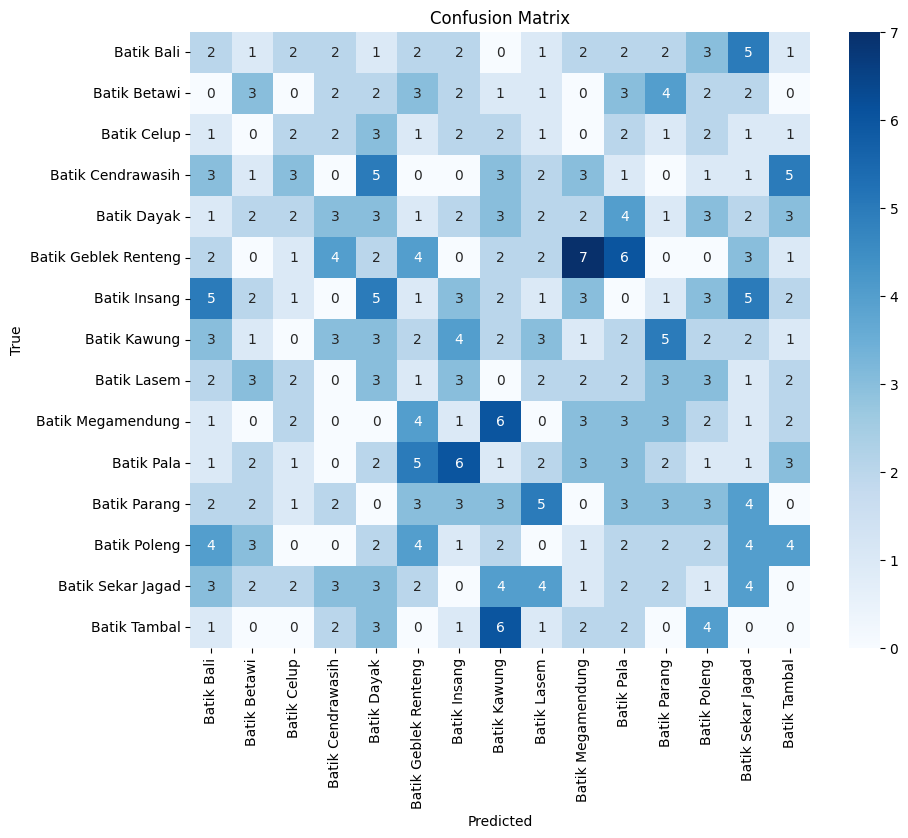

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Mengambil prediksi model
predictions = model.predict(testing_generator)

# Mengambil indeks kelas dengan prediksi tertinggi untuk setiap instance
predicted_classes = np.argmax(predictions, axis=1)

# Mengambil label asli dari testing_generator
true_classes = testing_generator.classes

# Verifikasi bahwa panjang prediksi dan true_classes sesuai
if len(predicted_classes) != len(true_classes):
    raise ValueError(f"Jumlah prediksi ({len(predicted_classes)}) tidak sesuai dengan jumlah label asli ({len(true_classes)}).")

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Menghitung laporan klasifikasi termasuk F1-score
class_report = classification_report(true_classes, predicted_classes, target_names=list(labels.values()))
print("\nClassification Report:")
print(class_report)

# Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Config

In [27]:
# model config pake h5
import h5py

# Replace 'your_model_name' with the actual file name of your HDF5 file
file_name = 'model.h5'

# Open the HDF5 file in read mode
with h5py.File(file_name, 'r') as f:
    # Retrieve the 'model_config' attribute
    model_config = f.attrs.get('model_config')

# Print the model configuration
print(model_config)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)